In [1]:
# LIBRARIES FOR NOTEBOOK
import xarray as xr
import rioxarray as rioxr

In [2]:
#LBRARIES FOR FUNCTIONS
import os
import numpy as np
import geopandas as gpd

from rasterio.features import shapes
from shapely.geometry import Polygon

import shapely
#import cv2
# pip install opencv-python-headless
# https://pypi.org/project/opencv-python/

## FUNCTIONS

In [10]:
# EXTRACT POLYGONS FROM REGIONS
# we are reusing the functions previoysly coded in temp_increase_regions.ipynb notebook @ Aurora server

# ------------------------------------------------------------------

# shape is a single JSON-ish polygon coming from the rasterio.features.shapes function
# rasterio.features.shapes returns a list of pairs (shape, value), example of a pair:
#   ({'type': 'Polygon', 'coordinates': [[(6,0),(6,2),(8,0),(6,0)]]}, 1.0)
#   shape is the first entry (the dictionary)
def create_polygon(shape):
    
    poly_list = shape.get('coordinates')

    if len(poly_list) == 1:    # polygon without holes
        return Polygon(poly_list[0])

    holes = []
    for i in range(1,len(poly_list)):
        holes.append(poly_list[i])
    return Polygon(shell=poly_list[0], holes=holes)

# ------------------------------------------------------------------
# ------------------------------------------------------------------

# shapes_list is the output from rasterio.features.shapes (type generator, iterable once)
# crs that will be assigned to the GeoDataFrame
def shapes_2_GeoDataFrame(shapes_list, crs = False):

    df = gpd.GeoDataFrame() 
    i = 0
    for shape, value in shapes_list:
        df.loc[i,'geometry'] = create_polygon(shape)
        i = i+1

    if(crs != False):
        df.crs = crs
    
    return df

# ------------------------------------------------------------------
# ------------------------------------------------------------------
def thick_regions(regions, crs, iterations=1):
    
    np_rgns = regions.to_numpy()
    thick_regions = cv2.dilate(np_rgns, 
               np.ones((3,3), np.uint8), 
               iterations)
    thick_regions = thick_regions.astype('uint8')  
    
    thick_shps = shapes(source = thick_regions, 
                     mask= thick_regions,   # include this so regions with value 0 are not inclduded
                     connectivity = 8,
                     transform = regions.rio.transform())

    return shapes_2_GeoDataFrame(thick_shps,crs)

# ------------------------------------------------------------------
# ------------------------------------------------------------------

def export_regions(regions,file_name,parent_dir):
    
    new_dir = parent_dir + file_name
    outfp = os.path.join(new_dir, file_name+'.shp')

    os.mkdir(new_dir)
    regions.to_file(outfp)
    return

def extract_polys(geo_df):
    polys = []
    for i in range(0, len(geo_df['geometry'])):
        polys.append(geo_df['geometry'][i])
    return shapely.geometry.MultiPolygon(polys)

# ------------------------------------------------------------------
# ------------------------------------------------------------------

def intersect_geodf(df1,crs,df2):
    
    df2.to_crs(crs,inplace=True)
    
    polys1 = extract_polys(df1)
    polys2 = extract_polys(df2)
    
    inter = polys1.intersection(polys2)

    df = gpd.GeoDataFrame() 
    for i in range(0,len(inter.geoms)):
        df.loc[i,'geometry'] = inter.geoms[i]    
    df.crs = more_arid.crs
    
    return df

## TRIAL: CLIMATE DATA

<xarray.DataArray (y: 1149, x: 706)>
[811194 values with dtype=float32]
Coordinates:
  * y            (y) float32 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float32 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
    spatial_ref  int64 ...
Attributes:
    long_name:       increase in climate regions from 2008 to 2019
    years_compared:  [2008 2019]

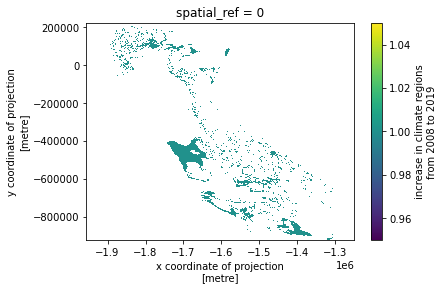

In [5]:
fp = "/home/jovyan/climate_layer/clim_increase_2008_2019.nc"
clim_rgns = xr.open_dataarray(fp)
#clim_rgns = rioxxr.open_rasterio(fp)
clim_rgns.plot()
clim_rgns

In [6]:
print('current crs: ', clim_rgns.rio.crs, '\n')
print('current coords: ', clim_rgns.coords, '\n')
print('current attrs: ',[*clim_rgns.attrs])

current crs:  PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown based on WGS84 ellipsoid",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",42.5],PARAMETER["central_meridian",-100],PARAMETER["standard_parallel_1",25],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]] 

current coords:  Coordinates:
  * y            (y) float32 2.24e+05 2.23e+05 2.22e+05 ... -9.23e+05 -9.24e+05
  * x            (x) float32 -1.955e+06 -1.954e+06 ... -1.251e+06 -1.25e+06
    lat          (y, x) float32 ...
    lon          (y, x) float32 ...
    spatial_ref  int64 0 

current attrs:  ['long_name', 'years_compared']


In [7]:
clim_polygons = thick_regions(clim_rgns, clim_rgns.rio.crs)
clim_polygons

,geometry
0,"POLYGON ((-1845750.000 209500.000, -1845750.00..."
1,"POLYGON ((-1843750.000 207500.000, -1843750.00..."
2,"POLYGON ((-1833750.000 207500.000, -1833750.00..."
3,"POLYGON ((-1870750.000 206500.000, -1870750.00..."
4,"POLYGON ((-1846750.000 206500.000, -1846750.00..."
...,...
2733,"POLYGON ((-1367750.000 -901500.000, -1367750.0..."
2734,"POLYGON ((-1363750.000 -901500.000, -1363750.0..."
2735,"POLYGON ((-1456750.000 -903500.000, -1456750.0..."
2736,"POLYGON ((-1453750.000 -907500.000, -1453750.0..."


In [8]:
clim_polygons.crs

<Derived Projected CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["Unknown b ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
#----- SAVE RESULTS -----
file_name = "clim_increase_2008_2019"
parent_dir = "/home/jovyan/layers_data/"

export_regions(clim_polygons,file_name,parent_dir)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## TRIAL: ARIDITY DATA

<xarray.DataArray (lat: 227, lon: 249)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    crs      int64 ...
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1
Attributes:
    long_name:          Transition to More Arid Moisture Domain (2008-2019)
    years_compared:     ['2008', '2019']
    coordinate_system:  EPSG:4326

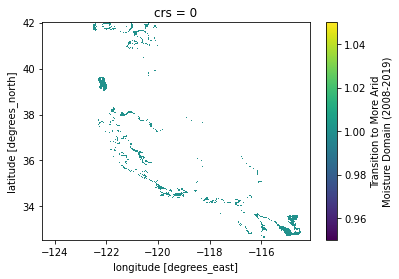

In [10]:
fp = "/home/jovyan/aridity_layer/arid_increase_2008_2019.nc"
aridity_regions = xr.open_dataarray(fp)
aridity_regions.plot()
aridity_regions

In [11]:
print('current crs: ', aridity_regions.rio.crs, '\n')
print('current coords: ', aridity_regions.coords, '\n')
print('current attrs: ',[*aridity_regions.attrs])

current crs:  None 

current coords:  Coordinates:
    crs      int64 0
  * lat      (lat) float64 41.98 41.94 41.9 41.86 ... 32.69 32.65 32.61 32.57
  * lon      (lon) float64 -124.5 -124.4 -124.4 -124.3 ... -114.2 -114.2 -114.1 

current attrs:  ['long_name', 'years_compared', 'coordinate_system']


In [13]:
arid_polygons = thick_regions(aridity_regions, aridity_regions.attrs['coordinate_system'])
arid_polygons

,geometry
0,"POLYGON ((-122.16250 42.00417, -121.87083 42.0..."
1,"POLYGON ((-121.74583 41.87917, -121.74583 41.8..."
2,"POLYGON ((-121.28750 41.87917, -121.28750 41.8..."
3,"POLYGON ((-120.20417 41.87917, -120.20417 41.7..."
4,"POLYGON ((-122.49583 42.00417, -122.45417 42.0..."
...,...
205,"POLYGON ((-115.87083 32.92083, -115.87083 32.8..."
206,"POLYGON ((-115.28750 32.92083, -115.28750 32.8..."
207,"POLYGON ((-115.41250 33.29583, -115.37083 33.2..."
208,"POLYGON ((-116.03750 32.79583, -116.03750 32.7..."


In [14]:
print(arid_polygons.crs)
type(arid_polygons)

EPSG:4326


geopandas.geodataframe.GeoDataFrame

In [15]:
# ----- SAVE RESULTS -----
file_name = "arid_increase_2008_2019"
parent_dir = "/home/jovyan/layers_data/"

export_regions(arid_polygons,file_name,parent_dir)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## OPEN SAVED POLYGONS

In [3]:
file = "/home/jovyan/layers_data/arid_increase_2008_2019/arid_increase_2008_2019.shp"
more_arid = gpd.read_file(file)
print(more_arid.crs)

epsg:4326


In [4]:
file = "/home/jovyan/layers_data/clim_increase_2008_2019/clim_increase_2008_2019.shp"
hotter = gpd.read_file(file)
hotter.crs

<Derived Projected CRS: PROJCS["unknown",GEOGCS["GCS_unknown",DATUM["D_Unk ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Lambert Conic Conformal (2SP)
Datum: D_Unknown_based_on_WGS84_ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## INTERSECT ARIDITY AND CLIMATE POLYGONS

In [7]:
arid_n_hot = intersect_geodf(more_arid,more_arid.crs,hotter)

In [8]:
arid_n_hot

,geometry
0,"POLYGON ((-122.15105 42.00417, -122.16250 42.0..."
1,"POLYGON ((-122.20417 41.96250, -122.20226 41.9..."
2,"POLYGON ((-122.41250 41.85694, -122.41446 41.8..."
3,"POLYGON ((-122.41250 41.84308, -122.41993 41.8..."
4,"POLYGON ((-122.53750 41.84665, -122.52736 41.8..."
...,...
115,"POLYGON ((-116.71997 33.76548, -116.71774 33.7..."
116,"POLYGON ((-115.97389 33.00601, -115.97179 32.9..."
117,"POLYGON ((-115.98053 32.98596, -115.99137 32.9..."
118,"POLYGON ((-114.67505 33.02939, -114.67311 33.0..."


In [12]:
file_name = "arid_n_hot_2008_2019"
parent_dir = "/home/jovyan/layers_data/"

export_regions(arid_n_hot,file_name,parent_dir)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


## INTERSECT WITH LESS BIOMASS

In [33]:
file = "/home/jovyan/layers_data/less_biomass_2008_2019/ca_less_bio.shp"
less_bio = gpd.read_file(file)
less_bio.crs

<Derived Projected CRS: PROJCS["unknown",GEOGCS["WGS 84",DATUM["WGS_1984", ...>
Name: unknown
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [43]:
all_inter = intersect_geodf(arid_n_hot,arid_n_hot.crs,less_bio)

In [47]:
#----- SAVE RESULTS -----
file_name = "change_intersections_2008_2019"
parent_dir = "/home/jovyan/layers_data/"

export_regions(all_inter,file_name,parent_dir)

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
